<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[16:10:29] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


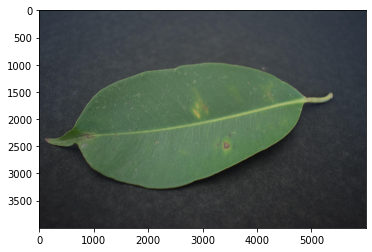

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

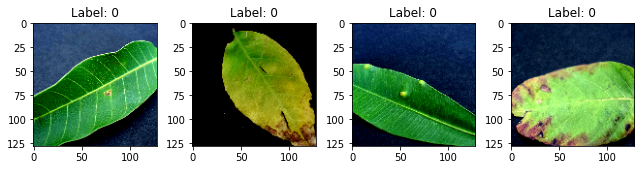

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[16:10:36] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[16:10:38] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.262429697032813 samples/sec                   batch loss = 1.4716535806655884 | accuracy = 0.4


Epoch[1] Batch[10] Speed: 1.264403135094577 samples/sec                   batch loss = 0.5506797432899475 | accuracy = 0.5


Epoch[1] Batch[15] Speed: 1.2664880053572727 samples/sec                   batch loss = 0.850082278251648 | accuracy = 0.48333333333333334


Epoch[1] Batch[20] Speed: 1.266008725892605 samples/sec                   batch loss = 0.5179678201675415 | accuracy = 0.5625


Epoch[1] Batch[25] Speed: 1.2700429070186434 samples/sec                   batch loss = 2.0525732040405273 | accuracy = 0.59


Epoch[1] Batch[30] Speed: 1.272977606292679 samples/sec                   batch loss = 0.33654171228408813 | accuracy = 0.625


Epoch[1] Batch[35] Speed: 1.271432054210491 samples/sec                   batch loss = 0.4538765549659729 | accuracy = 0.6357142857142857


Epoch[1] Batch[40] Speed: 1.2720673394679192 samples/sec                   batch loss = 0.32190752029418945 | accuracy = 0.6625


Epoch[1] Batch[45] Speed: 1.2743938996991917 samples/sec                   batch loss = 0.9427403807640076 | accuracy = 0.6666666666666666


Epoch[1] Batch[50] Speed: 1.2723855097200827 samples/sec                   batch loss = 0.6709986925125122 | accuracy = 0.665


Epoch[1] Batch[55] Speed: 1.270059636091001 samples/sec                   batch loss = 0.4339441955089569 | accuracy = 0.6681818181818182


Epoch[1] Batch[60] Speed: 1.2716604524603172 samples/sec                   batch loss = 0.8365386724472046 | accuracy = 0.6833333333333333


Epoch[1] Batch[65] Speed: 1.2658254245726923 samples/sec                   batch loss = 0.4349002242088318 | accuracy = 0.6846153846153846


Epoch[1] Batch[70] Speed: 1.2721708382798003 samples/sec                   batch loss = 0.9457036256790161 | accuracy = 0.675


Epoch[1] Batch[75] Speed: 1.2709839768081932 samples/sec                   batch loss = 0.31487661600112915 | accuracy = 0.69


Epoch[1] Batch[80] Speed: 1.271870130669574 samples/sec                   batch loss = 0.8547148704528809 | accuracy = 0.684375


Epoch[1] Batch[85] Speed: 1.2813360610921438 samples/sec                   batch loss = 0.21994425356388092 | accuracy = 0.6852941176470588


Epoch[1] Batch[90] Speed: 1.2652719266418704 samples/sec                   batch loss = 1.7541565895080566 | accuracy = 0.6777777777777778


Epoch[1] Batch[95] Speed: 1.2728451983885443 samples/sec                   batch loss = 0.9433539509773254 | accuracy = 0.6710526315789473


Epoch[1] Batch[100] Speed: 1.2703529471627206 samples/sec                   batch loss = 0.3749716877937317 | accuracy = 0.6725


Epoch[1] Batch[105] Speed: 1.2725350024157907 samples/sec                   batch loss = 0.5212021470069885 | accuracy = 0.680952380952381


Epoch[1] Batch[110] Speed: 1.2621280693307655 samples/sec                   batch loss = 0.3160519003868103 | accuracy = 0.6840909090909091


Epoch[1] Batch[115] Speed: 1.2609502919757183 samples/sec                   batch loss = 0.4891550838947296 | accuracy = 0.6782608695652174


Epoch[1] Batch[120] Speed: 1.259971214117624 samples/sec                   batch loss = 0.9726300239562988 | accuracy = 0.6770833333333334


Epoch[1] Batch[125] Speed: 1.2603441430660367 samples/sec                   batch loss = 0.4877244234085083 | accuracy = 0.676


Epoch[1] Batch[130] Speed: 1.265909379349456 samples/sec                   batch loss = 0.6468119025230408 | accuracy = 0.675


Epoch[1] Batch[135] Speed: 1.2635449567529309 samples/sec                   batch loss = 0.2551104426383972 | accuracy = 0.6759259259259259


Epoch[1] Batch[140] Speed: 1.2672948547071237 samples/sec                   batch loss = 0.6370889544487 | accuracy = 0.6696428571428571


Epoch[1] Batch[145] Speed: 1.2716715371633016 samples/sec                   batch loss = 0.4065781235694885 | accuracy = 0.6689655172413793


Epoch[1] Batch[150] Speed: 1.26940781680934 samples/sec                   batch loss = 0.3771239221096039 | accuracy = 0.67


Epoch[1] Batch[155] Speed: 1.26261087589388 samples/sec                   batch loss = 0.42222827672958374 | accuracy = 0.6725806451612903


Epoch[1] Batch[160] Speed: 1.2662065101361633 samples/sec                   batch loss = 0.8240203261375427 | accuracy = 0.675


Epoch[1] Batch[165] Speed: 1.2593448308527329 samples/sec                   batch loss = 0.3868066370487213 | accuracy = 0.6757575757575758


Epoch[1] Batch[170] Speed: 1.2559291113238775 samples/sec                   batch loss = 0.5624009370803833 | accuracy = 0.6735294117647059


Epoch[1] Batch[175] Speed: 1.2684771348164328 samples/sec                   batch loss = 1.0057144165039062 | accuracy = 0.6728571428571428


Epoch[1] Batch[180] Speed: 1.268078770887185 samples/sec                   batch loss = 1.132572054862976 | accuracy = 0.6722222222222223


Epoch[1] Batch[185] Speed: 1.2673418585154954 samples/sec                   batch loss = 0.6058092713356018 | accuracy = 0.6716216216216216


Epoch[1] Batch[190] Speed: 1.2744217794867756 samples/sec                   batch loss = 0.22370535135269165 | accuracy = 0.675


Epoch[1] Batch[195] Speed: 1.268936882529134 samples/sec                   batch loss = 0.7857760787010193 | accuracy = 0.6717948717948717


Epoch[1] Batch[200] Speed: 1.2687421782261479 samples/sec                   batch loss = 0.4209597706794739 | accuracy = 0.6725


Epoch[1] Batch[205] Speed: 1.2713062293051673 samples/sec                   batch loss = 0.2471846640110016 | accuracy = 0.6731707317073171


Epoch[1] Batch[210] Speed: 1.2724802776439312 samples/sec                   batch loss = 0.7733712196350098 | accuracy = 0.6702380952380952


Epoch[1] Batch[215] Speed: 1.2724970709886767 samples/sec                   batch loss = 0.3201194405555725 | accuracy = 0.6686046511627907


Epoch[1] Batch[220] Speed: 1.2749087107356236 samples/sec                   batch loss = 0.3237893879413605 | accuracy = 0.6670454545454545


Epoch[1] Batch[225] Speed: 1.2718070753316724 samples/sec                   batch loss = 0.29995155334472656 | accuracy = 0.6744444444444444


Epoch[1] Batch[230] Speed: 1.2689390899682644 samples/sec                   batch loss = 0.5099707245826721 | accuracy = 0.6739130434782609


Epoch[1] Batch[235] Speed: 1.2654471454264937 samples/sec                   batch loss = 0.5541173815727234 | accuracy = 0.676595744680851


Epoch[1] Batch[240] Speed: 1.2717490390940491 samples/sec                   batch loss = 0.6573793888092041 | accuracy = 0.6770833333333334


Epoch[1] Batch[245] Speed: 1.2699917610941365 samples/sec                   batch loss = 0.6799662113189697 | accuracy = 0.676530612244898


Epoch[1] Batch[250] Speed: 1.2706145410142988 samples/sec                   batch loss = 0.973303496837616 | accuracy = 0.673


Epoch[1] Batch[255] Speed: 1.2685906975850887 samples/sec                   batch loss = 0.7117823362350464 | accuracy = 0.6686274509803921


Epoch[1] Batch[260] Speed: 1.2753406553176467 samples/sec                   batch loss = 0.39116334915161133 | accuracy = 0.6701923076923076


Epoch[1] Batch[265] Speed: 1.2742755209940209 samples/sec                   batch loss = 0.44363534450531006 | accuracy = 0.6745283018867925


Epoch[1] Batch[270] Speed: 1.277297028527811 samples/sec                   batch loss = 0.7545867562294006 | accuracy = 0.6722222222222223


Epoch[1] Batch[275] Speed: 1.2769081699683924 samples/sec                   batch loss = 0.6295062303543091 | accuracy = 0.67


Epoch[1] Batch[280] Speed: 1.275566483893833 samples/sec                   batch loss = 1.0225335359573364 | accuracy = 0.6678571428571428


Epoch[1] Batch[285] Speed: 1.2787234423642475 samples/sec                   batch loss = 0.4803699254989624 | accuracy = 0.6666666666666666


Epoch[1] Batch[290] Speed: 1.2734001243099407 samples/sec                   batch loss = 0.4545464813709259 | accuracy = 0.6689655172413793


Epoch[1] Batch[295] Speed: 1.2684712845826358 samples/sec                   batch loss = 0.5489438772201538 | accuracy = 0.6669491525423729


Epoch[1] Batch[300] Speed: 1.2718536431197485 samples/sec                   batch loss = 0.5113980770111084 | accuracy = 0.67


Epoch[1] Batch[305] Speed: 1.2725420484515455 samples/sec                   batch loss = 0.5802357196807861 | accuracy = 0.6704918032786885


Epoch[1] Batch[310] Speed: 1.267844758915739 samples/sec                   batch loss = 0.6552421450614929 | accuracy = 0.6693548387096774


Epoch[1] Batch[315] Speed: 1.2731996034364792 samples/sec                   batch loss = 0.5728081464767456 | accuracy = 0.669047619047619


Epoch[1] Batch[320] Speed: 1.2805703712331589 samples/sec                   batch loss = 1.0214670896530151 | accuracy = 0.66796875


Epoch[1] Batch[325] Speed: 1.2770344258229676 samples/sec                   batch loss = 0.7650584578514099 | accuracy = 0.6676923076923077


Epoch[1] Batch[330] Speed: 1.2765739409240808 samples/sec                   batch loss = 0.47377291321754456 | accuracy = 0.6666666666666666


Epoch[1] Batch[335] Speed: 1.2759276460917206 samples/sec                   batch loss = 0.7641453742980957 | accuracy = 0.6664179104477612


Epoch[1] Batch[340] Speed: 1.2740356368474886 samples/sec                   batch loss = 0.34846431016921997 | accuracy = 0.6691176470588235


Epoch[1] Batch[345] Speed: 1.2755782186931959 samples/sec                   batch loss = 0.5825541615486145 | accuracy = 0.6688405797101449


Epoch[1] Batch[350] Speed: 1.2799727544861983 samples/sec                   batch loss = 0.4886869788169861 | accuracy = 0.6678571428571428


Epoch[1] Batch[355] Speed: 1.2756401936527206 samples/sec                   batch loss = 0.6918706297874451 | accuracy = 0.6669014084507042


Epoch[1] Batch[360] Speed: 1.274448014706441 samples/sec                   batch loss = 0.5589187145233154 | accuracy = 0.66875


Epoch[1] Batch[365] Speed: 1.2781367007386997 samples/sec                   batch loss = 0.7505325675010681 | accuracy = 0.6684931506849315


Epoch[1] Batch[370] Speed: 1.2799808596612172 samples/sec                   batch loss = 0.8868308663368225 | accuracy = 0.6682432432432432


Epoch[1] Batch[375] Speed: 1.2745601316159927 samples/sec                   batch loss = 1.4437516927719116 | accuracy = 0.666


Epoch[1] Batch[380] Speed: 1.2757026596427 samples/sec                   batch loss = 0.459442675113678 | accuracy = 0.6664473684210527


Epoch[1] Batch[385] Speed: 1.2777539481380387 samples/sec                   batch loss = 0.3869645595550537 | accuracy = 0.6675324675324675


Epoch[1] Batch[390] Speed: 1.2753503500497834 samples/sec                   batch loss = 0.5206068754196167 | accuracy = 0.6692307692307692


Epoch[1] Batch[395] Speed: 1.2830430572143265 samples/sec                   batch loss = 0.9960491061210632 | accuracy = 0.6683544303797468


Epoch[1] Batch[400] Speed: 1.2781141108014755 samples/sec                   batch loss = 0.8242005109786987 | accuracy = 0.66875


Epoch[1] Batch[405] Speed: 1.2718784228152507 samples/sec                   batch loss = 0.2837042212486267 | accuracy = 0.6679012345679012


Epoch[1] Batch[410] Speed: 1.2788376775167651 samples/sec                   batch loss = 1.1369038820266724 | accuracy = 0.6689024390243903


Epoch[1] Batch[415] Speed: 1.2718117030337819 samples/sec                   batch loss = 0.2952883243560791 | accuracy = 0.6692771084337349


Epoch[1] Batch[420] Speed: 1.2705805729466835 samples/sec                   batch loss = 0.2888103723526001 | accuracy = 0.6696428571428571


Epoch[1] Batch[425] Speed: 1.275774929950007 samples/sec                   batch loss = 0.6095385551452637 | accuracy = 0.6705882352941176


Epoch[1] Batch[430] Speed: 1.2790865897765877 samples/sec                   batch loss = 0.4021247923374176 | accuracy = 0.672093023255814


Epoch[1] Batch[435] Speed: 1.2735205638244809 samples/sec                   batch loss = 0.7121436595916748 | accuracy = 0.6729885057471264


Epoch[1] Batch[440] Speed: 1.278058223612593 samples/sec                   batch loss = 0.3615494966506958 | accuracy = 0.6710227272727273


Epoch[1] Batch[445] Speed: 1.2792633148574415 samples/sec                   batch loss = 0.4683555066585541 | accuracy = 0.6719101123595506


Epoch[1] Batch[450] Speed: 1.2704271138080405 samples/sec                   batch loss = 0.23290245234966278 | accuracy = 0.6711111111111111


Epoch[1] Batch[455] Speed: 1.2723042637379904 samples/sec                   batch loss = 0.9833095073699951 | accuracy = 0.6725274725274726


Epoch[1] Batch[460] Speed: 1.2819018450377353 samples/sec                   batch loss = 0.6860876083374023 | accuracy = 0.6733695652173913


Epoch[1] Batch[465] Speed: 1.2755991673015308 samples/sec                   batch loss = 0.7135242819786072 | accuracy = 0.6736559139784947


Epoch[1] Batch[470] Speed: 1.272430479296707 samples/sec                   batch loss = 0.5991992950439453 | accuracy = 0.6723404255319149


Epoch[1] Batch[475] Speed: 1.2753265012734096 samples/sec                   batch loss = 0.3568672835826874 | accuracy = 0.6736842105263158


Epoch[1] Batch[480] Speed: 1.2735054834723099 samples/sec                   batch loss = 1.0442065000534058 | accuracy = 0.6734375


Epoch[1] Batch[485] Speed: 1.275828289122375 samples/sec                   batch loss = 0.4964933395385742 | accuracy = 0.6737113402061856


Epoch[1] Batch[490] Speed: 1.2726342332304892 samples/sec                   batch loss = 0.2117919772863388 | accuracy = 0.675


Epoch[1] Batch[495] Speed: 1.2683418260061838 samples/sec                   batch loss = 0.8810176849365234 | accuracy = 0.6752525252525252


Epoch[1] Batch[500] Speed: 1.2689460962389851 samples/sec                   batch loss = 0.850516140460968 | accuracy = 0.676


Epoch[1] Batch[505] Speed: 1.2713039172887908 samples/sec                   batch loss = 0.5673492550849915 | accuracy = 0.6772277227722773


Epoch[1] Batch[510] Speed: 1.268310855760508 samples/sec                   batch loss = 0.48068341612815857 | accuracy = 0.6784313725490196


Epoch[1] Batch[515] Speed: 1.2672889196472727 samples/sec                   batch loss = 0.4056914448738098 | accuracy = 0.6786407766990291


Epoch[1] Batch[520] Speed: 1.2667207515814929 samples/sec                   batch loss = 0.6543498039245605 | accuracy = 0.6783653846153846


Epoch[1] Batch[525] Speed: 1.2723875361776749 samples/sec                   batch loss = 0.34667059779167175 | accuracy = 0.679047619047619


Epoch[1] Batch[530] Speed: 1.2718009051145795 samples/sec                   batch loss = 0.25333473086357117 | accuracy = 0.6797169811320755


Epoch[1] Batch[535] Speed: 1.272921684495965 samples/sec                   batch loss = 0.8264987468719482 | accuracy = 0.6785046728971963


Epoch[1] Batch[540] Speed: 1.2737964232724628 samples/sec                   batch loss = 0.9380743503570557 | accuracy = 0.6782407407407407


Epoch[1] Batch[545] Speed: 1.2806897269273667 samples/sec                   batch loss = 0.42569127678871155 | accuracy = 0.6798165137614679


Epoch[1] Batch[550] Speed: 1.2753970807261148 samples/sec                   batch loss = 0.571494996547699 | accuracy = 0.6795454545454546


Epoch[1] Batch[555] Speed: 1.2678612385039445 samples/sec                   batch loss = 0.5407852530479431 | accuracy = 0.6815315315315316


Epoch[1] Batch[560] Speed: 1.2634572238970703 samples/sec                   batch loss = 1.6936911344528198 | accuracy = 0.6808035714285714


Epoch[1] Batch[565] Speed: 1.2665379133246875 samples/sec                   batch loss = 0.5203148126602173 | accuracy = 0.6814159292035398


Epoch[1] Batch[570] Speed: 1.2812714766003526 samples/sec                   batch loss = 0.2857889235019684 | accuracy = 0.6824561403508772


Epoch[1] Batch[575] Speed: 1.2756495049650998 samples/sec                   batch loss = 0.15679877996444702 | accuracy = 0.6826086956521739


Epoch[1] Batch[580] Speed: 1.276516828584722 samples/sec                   batch loss = 0.7229220867156982 | accuracy = 0.6836206896551724


Epoch[1] Batch[585] Speed: 1.2705465104760993 samples/sec                   batch loss = 0.34239503741264343 | accuracy = 0.6841880341880342


Epoch[1] Batch[590] Speed: 1.275039416503511 samples/sec                   batch loss = 0.2848108410835266 | accuracy = 0.6847457627118644


Epoch[1] Batch[595] Speed: 1.273989392847876 samples/sec                   batch loss = 0.24996592104434967 | accuracy = 0.6840336134453782


Epoch[1] Batch[600] Speed: 1.2727423622407077 samples/sec                   batch loss = 0.6499203443527222 | accuracy = 0.685


Epoch[1] Batch[605] Speed: 1.274379476260098 samples/sec                   batch loss = 0.6454524397850037 | accuracy = 0.6847107438016529


Epoch[1] Batch[610] Speed: 1.2664838943399006 samples/sec                   batch loss = 0.372348815202713 | accuracy = 0.6856557377049181


Epoch[1] Batch[615] Speed: 1.2723911066186617 samples/sec                   batch loss = 0.3079914450645447 | accuracy = 0.6861788617886179


Epoch[1] Batch[620] Speed: 1.2739997442465343 samples/sec                   batch loss = 0.39626723527908325 | accuracy = 0.6858870967741936


Epoch[1] Batch[625] Speed: 1.2746183278745342 samples/sec                   batch loss = 0.2785870134830475 | accuracy = 0.686


Epoch[1] Batch[630] Speed: 1.279064941385776 samples/sec                   batch loss = 0.7621493339538574 | accuracy = 0.6857142857142857


Epoch[1] Batch[635] Speed: 1.2769797993636876 samples/sec                   batch loss = 0.7217333912849426 | accuracy = 0.6858267716535433


Epoch[1] Batch[640] Speed: 1.2730061968813002 samples/sec                   batch loss = 0.5992093682289124 | accuracy = 0.6859375


Epoch[1] Batch[645] Speed: 1.2799604504407938 samples/sec                   batch loss = 0.4028696119785309 | accuracy = 0.686046511627907


Epoch[1] Batch[650] Speed: 1.2770609631383463 samples/sec                   batch loss = 0.23968905210494995 | accuracy = 0.686923076923077


Epoch[1] Batch[655] Speed: 1.2796057855101097 samples/sec                   batch loss = 0.6843981742858887 | accuracy = 0.6866412213740458


Epoch[1] Batch[660] Speed: 1.2657717528378023 samples/sec                   batch loss = 0.3851328492164612 | accuracy = 0.6886363636363636


Epoch[1] Batch[665] Speed: 1.256354592213832 samples/sec                   batch loss = 0.7816457748413086 | accuracy = 0.6890977443609022


Epoch[1] Batch[670] Speed: 1.268654489645933 samples/sec                   batch loss = 0.26851049065589905 | accuracy = 0.6895522388059702


Epoch[1] Batch[675] Speed: 1.262591396909163 samples/sec                   batch loss = 0.41849881410598755 | accuracy = 0.6881481481481482


Epoch[1] Batch[680] Speed: 1.2583320957931132 samples/sec                   batch loss = 0.6344767808914185 | accuracy = 0.6889705882352941


Epoch[1] Batch[685] Speed: 1.2725113553319147 samples/sec                   batch loss = 0.4699230492115021 | accuracy = 0.6894160583941605


Epoch[1] Batch[690] Speed: 1.2729068114773943 samples/sec                   batch loss = 0.2760356366634369 | accuracy = 0.6894927536231884


Epoch[1] Batch[695] Speed: 1.2554924562166019 samples/sec                   batch loss = 0.47211897373199463 | accuracy = 0.6881294964028777


Epoch[1] Batch[700] Speed: 1.2575908162346685 samples/sec                   batch loss = 0.4267219007015228 | accuracy = 0.6889285714285714


Epoch[1] Batch[705] Speed: 1.2518955784635244 samples/sec                   batch loss = 0.30210912227630615 | accuracy = 0.6897163120567376


Epoch[1] Batch[710] Speed: 1.2676954082316554 samples/sec                   batch loss = 0.17708039283752441 | accuracy = 0.6901408450704225


Epoch[1] Batch[715] Speed: 1.2639365727019733 samples/sec                   batch loss = 0.6719915270805359 | accuracy = 0.6891608391608391


Epoch[1] Batch[720] Speed: 1.2662666220355632 samples/sec                   batch loss = 0.3847882151603699 | accuracy = 0.6885416666666667


Epoch[1] Batch[725] Speed: 1.2698393091533369 samples/sec                   batch loss = 0.6594754457473755 | accuracy = 0.6882758620689655


Epoch[1] Batch[730] Speed: 1.2580033688292118 samples/sec                   batch loss = 0.9633934497833252 | accuracy = 0.6883561643835616


Epoch[1] Batch[735] Speed: 1.2518131919131685 samples/sec                   batch loss = 1.2374461889266968 | accuracy = 0.6880952380952381


Epoch[1] Batch[740] Speed: 1.2581237437297095 samples/sec                   batch loss = 1.1825624704360962 | accuracy = 0.6864864864864865


Epoch[1] Batch[745] Speed: 1.2588312700856485 samples/sec                   batch loss = 0.6162380576133728 | accuracy = 0.6869127516778524


Epoch[1] Batch[750] Speed: 1.2554176744848715 samples/sec                   batch loss = 0.4087815582752228 | accuracy = 0.687


Epoch[1] Batch[755] Speed: 1.2715763114075078 samples/sec                   batch loss = 0.7100767493247986 | accuracy = 0.6867549668874172


Epoch[1] Batch[760] Speed: 1.2682759561197439 samples/sec                   batch loss = 0.43128225207328796 | accuracy = 0.6881578947368421


Epoch[1] Batch[765] Speed: 1.2765895797177584 samples/sec                   batch loss = 0.77970290184021 | accuracy = 0.6875816993464052


Epoch[1] Batch[770] Speed: 1.271327615855313 samples/sec                   batch loss = 0.6399445533752441 | accuracy = 0.688961038961039


Epoch[1] Batch[775] Speed: 1.2582833986429285 samples/sec                   batch loss = 1.1359577178955078 | accuracy = 0.6893548387096774


Epoch[1] Batch[780] Speed: 1.2644574532163548 samples/sec                   batch loss = 0.47416117787361145 | accuracy = 0.6903846153846154


Epoch[1] Batch[785] Speed: 1.267786125715279 samples/sec                   batch loss = 0.5439361333847046 | accuracy = 0.689171974522293


[Epoch 1] training: accuracy=0.6900380710659898
[Epoch 1] time cost: 648.4231467247009
[Epoch 1] validation: validation accuracy=0.7366666666666667


Epoch[2] Batch[5] Speed: 1.2525338342906456 samples/sec                   batch loss = 0.4161517024040222 | accuracy = 0.75


Epoch[2] Batch[10] Speed: 1.2511555160243462 samples/sec                   batch loss = 0.5556421875953674 | accuracy = 0.725


Epoch[2] Batch[15] Speed: 1.2566080049925126 samples/sec                   batch loss = 0.5339838266372681 | accuracy = 0.7833333333333333


Epoch[2] Batch[20] Speed: 1.26150267042323 samples/sec                   batch loss = 0.37612268328666687 | accuracy = 0.7875


Epoch[2] Batch[25] Speed: 1.277542909301713 samples/sec                   batch loss = 0.6390864849090576 | accuracy = 0.79


Epoch[2] Batch[30] Speed: 1.2711831261307016 samples/sec                   batch loss = 0.5826808214187622 | accuracy = 0.7833333333333333


Epoch[2] Batch[35] Speed: 1.2740453117490342 samples/sec                   batch loss = 0.7054789066314697 | accuracy = 0.75


Epoch[2] Batch[40] Speed: 1.275362177822591 samples/sec                   batch loss = 0.542062520980835 | accuracy = 0.75625


Epoch[2] Batch[45] Speed: 1.2711602034466585 samples/sec                   batch loss = 0.4252166152000427 | accuracy = 0.7444444444444445


Epoch[2] Batch[50] Speed: 1.2691395190524688 samples/sec                   batch loss = 0.4409264326095581 | accuracy = 0.755


Epoch[2] Batch[55] Speed: 1.2666771410112796 samples/sec                   batch loss = 0.24703986942768097 | accuracy = 0.7636363636363637


Epoch[2] Batch[60] Speed: 1.2736429598938586 samples/sec                   batch loss = 0.33777299523353577 | accuracy = 0.7541666666666667


Epoch[2] Batch[65] Speed: 1.2672058346460053 samples/sec                   batch loss = 0.3820706605911255 | accuracy = 0.7615384615384615


Epoch[2] Batch[70] Speed: 1.2794358932474459 samples/sec                   batch loss = 0.7908709049224854 | accuracy = 0.7571428571428571


Epoch[2] Batch[75] Speed: 1.2750745924613258 samples/sec                   batch loss = 0.13877339661121368 | accuracy = 0.7533333333333333


Epoch[2] Batch[80] Speed: 1.2684858623146904 samples/sec                   batch loss = 0.4829522669315338 | accuracy = 0.753125


Epoch[2] Batch[85] Speed: 1.273343392239665 samples/sec                   batch loss = 0.4189189076423645 | accuracy = 0.7529411764705882


Epoch[2] Batch[90] Speed: 1.2742399052136302 samples/sec                   batch loss = 0.32063403725624084 | accuracy = 0.7611111111111111


Epoch[2] Batch[95] Speed: 1.2719006964394897 samples/sec                   batch loss = 0.8304400444030762 | accuracy = 0.7526315789473684


Epoch[2] Batch[100] Speed: 1.2713899492299312 samples/sec                   batch loss = 0.263683944940567 | accuracy = 0.75


Epoch[2] Batch[105] Speed: 1.2713235696960434 samples/sec                   batch loss = 0.6244747638702393 | accuracy = 0.75


Epoch[2] Batch[110] Speed: 1.2712723205744256 samples/sec                   batch loss = 0.43186068534851074 | accuracy = 0.7522727272727273


Epoch[2] Batch[115] Speed: 1.2742769727664305 samples/sec                   batch loss = 0.7310011386871338 | accuracy = 0.7456521739130435


Epoch[2] Batch[120] Speed: 1.2733327615793464 samples/sec                   batch loss = 0.4875454306602478 | accuracy = 0.74375


Epoch[2] Batch[125] Speed: 1.26819887690594 samples/sec                   batch loss = 1.0263206958770752 | accuracy = 0.74


Epoch[2] Batch[130] Speed: 1.2718909576593203 samples/sec                   batch loss = 0.32399535179138184 | accuracy = 0.7403846153846154


Epoch[2] Batch[135] Speed: 1.2773719109860564 samples/sec                   batch loss = 0.3936113715171814 | accuracy = 0.7425925925925926


Epoch[2] Batch[140] Speed: 1.271294380310126 samples/sec                   batch loss = 0.5667086839675903 | accuracy = 0.7464285714285714


Epoch[2] Batch[145] Speed: 1.268348058591377 samples/sec                   batch loss = 0.3229803740978241 | accuracy = 0.7396551724137931


Epoch[2] Batch[150] Speed: 1.266247794642415 samples/sec                   batch loss = 0.31505393981933594 | accuracy = 0.7383333333333333


Epoch[2] Batch[155] Speed: 1.26983604135357 samples/sec                   batch loss = 0.7185835242271423 | accuracy = 0.7370967741935484


Epoch[2] Batch[160] Speed: 1.276928190401341 samples/sec                   batch loss = 0.4371618628501892 | accuracy = 0.740625


Epoch[2] Batch[165] Speed: 1.26469765242814 samples/sec                   batch loss = 0.2621791660785675 | accuracy = 0.7424242424242424


Epoch[2] Batch[170] Speed: 1.2698557445189405 samples/sec                   batch loss = 0.5745950937271118 | accuracy = 0.7382352941176471


Epoch[2] Batch[175] Speed: 1.2681596698065252 samples/sec                   batch loss = 0.2934941053390503 | accuracy = 0.7328571428571429


Epoch[2] Batch[180] Speed: 1.2667258205487055 samples/sec                   batch loss = 0.6283636689186096 | accuracy = 0.7319444444444444


Epoch[2] Batch[185] Speed: 1.2700855958689174 samples/sec                   batch loss = 0.4969310462474823 | accuracy = 0.731081081081081


Epoch[2] Batch[190] Speed: 1.2660014654248035 samples/sec                   batch loss = 0.5016883015632629 | accuracy = 0.7355263157894737


Epoch[2] Batch[195] Speed: 1.269996087187663 samples/sec                   batch loss = 0.6211158037185669 | accuracy = 0.7384615384615385


Epoch[2] Batch[200] Speed: 1.2642338259162562 samples/sec                   batch loss = 0.5671854019165039 | accuracy = 0.73875


Epoch[2] Batch[205] Speed: 1.272166304428351 samples/sec                   batch loss = 0.23035210371017456 | accuracy = 0.7414634146341463


Epoch[2] Batch[210] Speed: 1.2753953355355672 samples/sec                   batch loss = 0.7873797416687012 | accuracy = 0.7404761904761905


Epoch[2] Batch[215] Speed: 1.2726725590007786 samples/sec                   batch loss = 0.8514017462730408 | accuracy = 0.7395348837209302


Epoch[2] Batch[220] Speed: 1.2698224897752108 samples/sec                   batch loss = 0.5418895483016968 | accuracy = 0.7352272727272727


Epoch[2] Batch[225] Speed: 1.2660779911207396 samples/sec                   batch loss = 0.23699098825454712 | accuracy = 0.7355555555555555


Epoch[2] Batch[230] Speed: 1.2698397897135445 samples/sec                   batch loss = 0.919236421585083 | accuracy = 0.7369565217391304


Epoch[2] Batch[235] Speed: 1.2716469583001127 samples/sec                   batch loss = 0.43109917640686035 | accuracy = 0.7382978723404255


Epoch[2] Batch[240] Speed: 1.2646920276731588 samples/sec                   batch loss = 0.5818731188774109 | accuracy = 0.7385416666666667


Epoch[2] Batch[245] Speed: 1.2600562868466147 samples/sec                   batch loss = 0.47485488653182983 | accuracy = 0.7418367346938776


Epoch[2] Batch[250] Speed: 1.2556065249087662 samples/sec                   batch loss = 0.34554994106292725 | accuracy = 0.741


Epoch[2] Batch[255] Speed: 1.2666984677351283 samples/sec                   batch loss = 0.2121906578540802 | accuracy = 0.7401960784313726


Epoch[2] Batch[260] Speed: 1.25916146944961 samples/sec                   batch loss = 0.7550433278083801 | accuracy = 0.7403846153846154


Epoch[2] Batch[265] Speed: 1.2593078707267344 samples/sec                   batch loss = 0.7671282291412354 | accuracy = 0.7386792452830189


Epoch[2] Batch[270] Speed: 1.2657628716550928 samples/sec                   batch loss = 0.5897652506828308 | accuracy = 0.7388888888888889


Epoch[2] Batch[275] Speed: 1.2709366061770648 samples/sec                   batch loss = 0.15133227407932281 | accuracy = 0.7363636363636363


Epoch[2] Batch[280] Speed: 1.2656250860454805 samples/sec                   batch loss = 0.5246894359588623 | accuracy = 0.7375


Epoch[2] Batch[285] Speed: 1.2715589641213836 samples/sec                   batch loss = 0.728361964225769 | accuracy = 0.7350877192982456


Epoch[2] Batch[290] Speed: 1.2639145771387412 samples/sec                   batch loss = 0.799230694770813 | accuracy = 0.7353448275862069


Epoch[2] Batch[295] Speed: 1.2699283151083267 samples/sec                   batch loss = 0.47478169202804565 | accuracy = 0.7389830508474576


Epoch[2] Batch[300] Speed: 1.2628686251905814 samples/sec                   batch loss = 0.3941919505596161 | accuracy = 0.74


Epoch[2] Batch[305] Speed: 1.2620931293428324 samples/sec                   batch loss = 0.4226979911327362 | accuracy = 0.740983606557377


Epoch[2] Batch[310] Speed: 1.2576898984595466 samples/sec                   batch loss = 0.4920760989189148 | accuracy = 0.7411290322580645


Epoch[2] Batch[315] Speed: 1.2707018270695314 samples/sec                   batch loss = 0.430136501789093 | accuracy = 0.7428571428571429


Epoch[2] Batch[320] Speed: 1.268655928638588 samples/sec                   batch loss = 0.2901362478733063 | accuracy = 0.74296875


Epoch[2] Batch[325] Speed: 1.2727949852356317 samples/sec                   batch loss = 0.47840416431427 | accuracy = 0.7407692307692307


Epoch[2] Batch[330] Speed: 1.27859811908193 samples/sec                   batch loss = 0.32660290598869324 | accuracy = 0.7401515151515151


Epoch[2] Batch[335] Speed: 1.2725000629529388 samples/sec                   batch loss = 0.8884426951408386 | accuracy = 0.7373134328358208


Epoch[2] Batch[340] Speed: 1.26704189816549 samples/sec                   batch loss = 0.45560574531555176 | accuracy = 0.7360294117647059


Epoch[2] Batch[345] Speed: 1.2753251440527984 samples/sec                   batch loss = 0.4677503705024719 | accuracy = 0.7355072463768116


Epoch[2] Batch[350] Speed: 1.282090322127064 samples/sec                   batch loss = 0.16373717784881592 | accuracy = 0.7385714285714285


Epoch[2] Batch[355] Speed: 1.258271508050899 samples/sec                   batch loss = 0.5582731366157532 | accuracy = 0.7387323943661972


Epoch[2] Batch[360] Speed: 1.2501260020178206 samples/sec                   batch loss = 0.18955789506435394 | accuracy = 0.7409722222222223


Epoch[2] Batch[365] Speed: 1.25387527072468 samples/sec                   batch loss = 0.6633630990982056 | accuracy = 0.7383561643835617


Epoch[2] Batch[370] Speed: 1.2716477293872666 samples/sec                   batch loss = 0.24914781749248505 | accuracy = 0.7391891891891892


Epoch[2] Batch[375] Speed: 1.2741890981033988 samples/sec                   batch loss = 0.670489490032196 | accuracy = 0.7393333333333333


Epoch[2] Batch[380] Speed: 1.2780603655402125 samples/sec                   batch loss = 0.2909281253814697 | accuracy = 0.7394736842105263


Epoch[2] Batch[385] Speed: 1.274652996391252 samples/sec                   batch loss = 0.15089425444602966 | accuracy = 0.7389610389610389


Epoch[2] Batch[390] Speed: 1.2757598931712175 samples/sec                   batch loss = 0.49754613637924194 | accuracy = 0.7391025641025641


Epoch[2] Batch[395] Speed: 1.2752550572291559 samples/sec                   batch loss = 0.48986688256263733 | accuracy = 0.739240506329114


Epoch[2] Batch[400] Speed: 1.265516253758049 samples/sec                   batch loss = 0.29121407866477966 | accuracy = 0.740625


Epoch[2] Batch[405] Speed: 1.2547351863766696 samples/sec                   batch loss = 0.8045218586921692 | accuracy = 0.7401234567901235


Epoch[2] Batch[410] Speed: 1.2607243980883105 samples/sec                   batch loss = 0.29550299048423767 | accuracy = 0.7420731707317073


Epoch[2] Batch[415] Speed: 1.2643445339337278 samples/sec                   batch loss = 0.12227629125118256 | accuracy = 0.7427710843373494


Epoch[2] Batch[420] Speed: 1.2678268426402077 samples/sec                   batch loss = 0.586866557598114 | accuracy = 0.7440476190476191


Epoch[2] Batch[425] Speed: 1.2671209422177028 samples/sec                   batch loss = 0.20785851776599884 | accuracy = 0.7458823529411764


Epoch[2] Batch[430] Speed: 1.2613795617189125 samples/sec                   batch loss = 0.8036172986030579 | accuracy = 0.7459302325581395


Epoch[2] Batch[435] Speed: 1.2556926069345793 samples/sec                   batch loss = 0.5238379240036011 | accuracy = 0.746551724137931


Epoch[2] Batch[440] Speed: 1.2644411572897971 samples/sec                   batch loss = 0.34030681848526 | accuracy = 0.7477272727272727


Epoch[2] Batch[445] Speed: 1.2700506946354315 samples/sec                   batch loss = 0.561604380607605 | accuracy = 0.7460674157303371


Epoch[2] Batch[450] Speed: 1.2748881723101988 samples/sec                   batch loss = 0.12370174378156662 | accuracy = 0.7472222222222222


Epoch[2] Batch[455] Speed: 1.272095117551464 samples/sec                   batch loss = 0.12664824724197388 | accuracy = 0.7461538461538462


Epoch[2] Batch[460] Speed: 1.2683451820059841 samples/sec                   batch loss = 0.5379238128662109 | accuracy = 0.7467391304347826


Epoch[2] Batch[465] Speed: 1.26878391610782 samples/sec                   batch loss = 0.6650316715240479 | accuracy = 0.7456989247311828


Epoch[2] Batch[470] Speed: 1.2722866071358154 samples/sec                   batch loss = 0.920154869556427 | accuracy = 0.7436170212765958


Epoch[2] Batch[475] Speed: 1.2696193468820716 samples/sec                   batch loss = 0.5588101744651794 | accuracy = 0.7442105263157894


Epoch[2] Batch[480] Speed: 1.2714577810516807 samples/sec                   batch loss = 0.5407940149307251 | accuracy = 0.7447916666666666


Epoch[2] Batch[485] Speed: 1.2711817777146375 samples/sec                   batch loss = 0.5531619191169739 | accuracy = 0.7453608247422681


Epoch[2] Batch[490] Speed: 1.2699608063515238 samples/sec                   batch loss = 0.28732165694236755 | accuracy = 0.7443877551020408


Epoch[2] Batch[495] Speed: 1.2642562136673252 samples/sec                   batch loss = 0.5154487490653992 | accuracy = 0.7454545454545455


Epoch[2] Batch[500] Speed: 1.27172686717906 samples/sec                   batch loss = 0.5605244636535645 | accuracy = 0.746


Epoch[2] Batch[505] Speed: 1.2685717050981151 samples/sec                   batch loss = 0.5673689246177673 | accuracy = 0.7465346534653465


Epoch[2] Batch[510] Speed: 1.270995049720971 samples/sec                   batch loss = 0.3960793614387512 | accuracy = 0.7475490196078431


Epoch[2] Batch[515] Speed: 1.2696574912762781 samples/sec                   batch loss = 0.38251057267189026 | accuracy = 0.7495145631067961


Epoch[2] Batch[520] Speed: 1.2690644467212728 samples/sec                   batch loss = 0.5911998748779297 | accuracy = 0.7495192307692308


Epoch[2] Batch[525] Speed: 1.2688300708477094 samples/sec                   batch loss = 0.700185239315033 | accuracy = 0.7471428571428571


Epoch[2] Batch[530] Speed: 1.2678129506895348 samples/sec                   batch loss = 0.1342484951019287 | accuracy = 0.7462264150943396


Epoch[2] Batch[535] Speed: 1.2714752219369054 samples/sec                   batch loss = 0.6928655505180359 | accuracy = 0.7467289719626168


Epoch[2] Batch[540] Speed: 1.2699458101865344 samples/sec                   batch loss = 0.1700405329465866 | accuracy = 0.7476851851851852


Epoch[2] Batch[545] Speed: 1.2650432417987767 samples/sec                   batch loss = 0.4949202239513397 | accuracy = 0.7472477064220183


Epoch[2] Batch[550] Speed: 1.2642177262790235 samples/sec                   batch loss = 0.291836678981781 | accuracy = 0.7481818181818182


Epoch[2] Batch[555] Speed: 1.2731446282631738 samples/sec                   batch loss = 0.42638322710990906 | accuracy = 0.7472972972972973


Epoch[2] Batch[560] Speed: 1.2718370595827182 samples/sec                   batch loss = 0.6314250826835632 | accuracy = 0.7482142857142857


Epoch[2] Batch[565] Speed: 1.2749135548003254 samples/sec                   batch loss = 0.2686674892902374 | accuracy = 0.7486725663716814


Epoch[2] Batch[570] Speed: 1.2708682523442054 samples/sec                   batch loss = 0.7641206383705139 | accuracy = 0.7482456140350877


Epoch[2] Batch[575] Speed: 1.2749391320722514 samples/sec                   batch loss = 0.8801896572113037 | accuracy = 0.7486956521739131


Epoch[2] Batch[580] Speed: 1.2779148281532506 samples/sec                   batch loss = 0.3887648582458496 | accuracy = 0.7491379310344828


Epoch[2] Batch[585] Speed: 1.2726562437181566 samples/sec                   batch loss = 0.4890756607055664 | accuracy = 0.7487179487179487


Epoch[2] Batch[590] Speed: 1.2735042267924168 samples/sec                   batch loss = 0.3481125831604004 | accuracy = 0.7491525423728813


Epoch[2] Batch[595] Speed: 1.2716169830117736 samples/sec                   batch loss = 0.5030763149261475 | accuracy = 0.75


Epoch[2] Batch[600] Speed: 1.2784638574759377 samples/sec                   batch loss = 0.40173929929733276 | accuracy = 0.75


Epoch[2] Batch[605] Speed: 1.2700332928086624 samples/sec                   batch loss = 0.687574028968811 | accuracy = 0.7512396694214876


Epoch[2] Batch[610] Speed: 1.2743790890581794 samples/sec                   batch loss = 0.5775755643844604 | accuracy = 0.7508196721311475


Epoch[2] Batch[615] Speed: 1.277651874084867 samples/sec                   batch loss = 0.2727357745170593 | accuracy = 0.7504065040650406


Epoch[2] Batch[620] Speed: 1.2752697913022049 samples/sec                   batch loss = 0.737562358379364 | accuracy = 0.7491935483870967


Epoch[2] Batch[625] Speed: 1.2721893598809555 samples/sec                   batch loss = 0.1995597630739212 | accuracy = 0.7496


Epoch[2] Batch[630] Speed: 1.2729243887185009 samples/sec                   batch loss = 0.5695447325706482 | accuracy = 0.75


Epoch[2] Batch[635] Speed: 1.268824697150184 samples/sec                   batch loss = 0.36586493253707886 | accuracy = 0.7492125984251968


Epoch[2] Batch[640] Speed: 1.2648941689182327 samples/sec                   batch loss = 0.5909906029701233 | accuracy = 0.74921875


Epoch[2] Batch[645] Speed: 1.2695256770502041 samples/sec                   batch loss = 0.595241129398346 | accuracy = 0.7496124031007751


Epoch[2] Batch[650] Speed: 1.2650709047391326 samples/sec                   batch loss = 0.35714343190193176 | accuracy = 0.7496153846153846


Epoch[2] Batch[655] Speed: 1.2654350236105398 samples/sec                   batch loss = 0.5666805505752563 | accuracy = 0.749236641221374


Epoch[2] Batch[660] Speed: 1.259516993425927 samples/sec                   batch loss = 0.28466475009918213 | accuracy = 0.75


Epoch[2] Batch[665] Speed: 1.2662654751732667 samples/sec                   batch loss = 0.6196914911270142 | accuracy = 0.7484962406015038


Epoch[2] Batch[670] Speed: 1.264936226230445 samples/sec                   batch loss = 0.17912767827510834 | accuracy = 0.7488805970149254


Epoch[2] Batch[675] Speed: 1.2615661310587687 samples/sec                   batch loss = 0.23314104974269867 | accuracy = 0.7488888888888889


Epoch[2] Batch[680] Speed: 1.2632604877807834 samples/sec                   batch loss = 0.4949946999549866 | accuracy = 0.7485294117647059


Epoch[2] Batch[685] Speed: 1.2723328240882408 samples/sec                   batch loss = 0.10530281811952591 | accuracy = 0.7481751824817519


Epoch[2] Batch[690] Speed: 1.2674138548148792 samples/sec                   batch loss = 0.43188047409057617 | accuracy = 0.7485507246376811


Epoch[2] Batch[695] Speed: 1.2694368235750686 samples/sec                   batch loss = 0.22420530021190643 | accuracy = 0.7485611510791367


Epoch[2] Batch[700] Speed: 1.2680655443205386 samples/sec                   batch loss = 0.5083590745925903 | accuracy = 0.7489285714285714


Epoch[2] Batch[705] Speed: 1.2662982571395447 samples/sec                   batch loss = 0.61955326795578 | accuracy = 0.749290780141844


Epoch[2] Batch[710] Speed: 1.2574336930929952 samples/sec                   batch loss = 0.4326711595058441 | accuracy = 0.7489436619718309


Epoch[2] Batch[715] Speed: 1.2538605583310813 samples/sec                   batch loss = 1.7673615217208862 | accuracy = 0.7482517482517482


Epoch[2] Batch[720] Speed: 1.2628676745942704 samples/sec                   batch loss = 0.4857255220413208 | accuracy = 0.7486111111111111


Epoch[2] Batch[725] Speed: 1.2693686309660674 samples/sec                   batch loss = 0.6055984497070312 | accuracy = 0.7472413793103448


Epoch[2] Batch[730] Speed: 1.2630922452013162 samples/sec                   batch loss = 0.32067927718162537 | accuracy = 0.7469178082191781


Epoch[2] Batch[735] Speed: 1.274476961829462 samples/sec                   batch loss = 0.2958068251609802 | accuracy = 0.7472789115646259


Epoch[2] Batch[740] Speed: 1.2727412036182193 samples/sec                   batch loss = 0.3665713369846344 | accuracy = 0.7472972972972973


Epoch[2] Batch[745] Speed: 1.2730287998096361 samples/sec                   batch loss = 0.38438549637794495 | accuracy = 0.7469798657718121


Epoch[2] Batch[750] Speed: 1.2729918048366389 samples/sec                   batch loss = 0.28361037373542786 | accuracy = 0.7483333333333333


Epoch[2] Batch[755] Speed: 1.2732283006237197 samples/sec                   batch loss = 0.266033798456192 | accuracy = 0.7490066225165563


Epoch[2] Batch[760] Speed: 1.2745138495337909 samples/sec                   batch loss = 0.7431097626686096 | accuracy = 0.7480263157894737


Epoch[2] Batch[765] Speed: 1.2795686024738822 samples/sec                   batch loss = 0.26597943902015686 | accuracy = 0.7477124183006536


Epoch[2] Batch[770] Speed: 1.2707240595024767 samples/sec                   batch loss = 0.1892344355583191 | accuracy = 0.7474025974025974


Epoch[2] Batch[775] Speed: 1.2718715769662678 samples/sec                   batch loss = 0.07723712176084518 | accuracy = 0.747741935483871


Epoch[2] Batch[780] Speed: 1.2774792902463044 samples/sec                   batch loss = 0.32651403546333313 | accuracy = 0.7487179487179487


Epoch[2] Batch[785] Speed: 1.2738692515368504 samples/sec                   batch loss = 0.8172799944877625 | accuracy = 0.7484076433121019


[Epoch 2] training: accuracy=0.7480964467005076
[Epoch 2] time cost: 638.3492226600647
[Epoch 2] validation: validation accuracy=0.7222222222222222


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7177777777777777

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)